In [1]:
import math
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import numpy as np
import time
from numpy import arange, sin, pi, random

from pyspark import SparkContext

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Anomaly"]
lookback = 3

In [2]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util import common
from bigdl.util.common import *

sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

## Read data from csv

In [3]:
df = pd.read_csv("data/CPU_examples.csv")

In [4]:
df.shape

(100001, 3)

In [5]:
df.head()

,Time,CPU,Class
0,0,0.441271,0
1,1,0.400604,0
2,2,0.330440,0
3,3,0.227240,0
4,4,0.328483,0


## Basic sanity check of data and normalization

In [6]:
# check for null data
df.isnull().values.any()

# Standard scaling : mean 0, stddev 1
scaler = preprocessing.StandardScaler()
df['CPU'] = scaler.fit_transform(df['CPU'].values.reshape(-1, 1))

scaler_mean = scaler.mean_
scaler_var = scaler.var_ ** 0.5

print(scaler_mean)  ## mean
print(scaler_var)   ## std dev

df.head()

[0.34964777]
[0.18103937]


,Time,CPU,Class
0,0,0.506097,0
1,1,0.281467,0
2,2,-0.106098,0
3,3,-0.676137,0
4,4,-0.116907,0


<bound method Series.count of 0    83441
1    16560
Name: Class, dtype: int64>


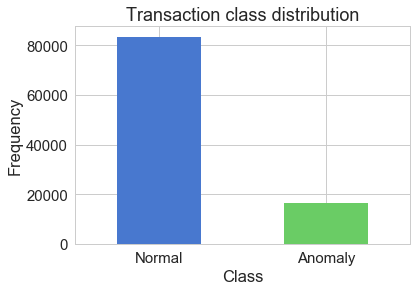

In [7]:
# let's explore the distribution of input data
count_classes = pd.value_counts(df['Class'], sort = False)
print(count_classes.count)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# Just checking the relative counts
anomaly = df[df.Class == 1]
normal = df[df.Class == 0]

anomaly.shape

(16560, 3)

In [9]:
normal.shape

(83441, 3)

In [10]:
anomaly.CPU.describe()

count    16560.000000
mean         1.381443
std          0.547092
min         -0.812502
25%          1.013223
50%          1.383492
75%          1.751278
max          3.658377
Name: CPU, dtype: float64

In [11]:
normal.CPU.describe()

count    83441.000000
mean        -0.274166
std          0.827745
min         -4.338766
25%         -0.835627
50%         -0.273015
75%          0.287959
max          3.306589
Name: CPU, dtype: float64

## Any correlation between time and CPU metrics ?

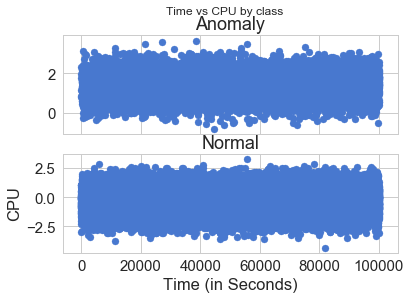

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs CPU by class')

ax1.scatter(anomaly.Time, anomaly.CPU)
ax1.set_title('Anomaly')

ax2.scatter(normal.Time, normal.CPU)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('CPU')
plt.show()

## Feature Re-engineering

In [13]:
def widenX(width, x) :
    slicestart = 0
    sliceend = width

    X_data = []
    newlength = x.size - width + 1
    for i in range(newlength):
        X_data.append(x[slicestart:sliceend])
        slicestart = slicestart + 1
        sliceend = sliceend + 1

    return np.reshape(X_data, newshape=(newlength, width))

def widenY(width, y):
    return y[width-1:]

In [14]:
df.head()
anomaly = df[df.Class == 1]
anomaly.shape

(16560, 3)

In [15]:
X_train = widenX(lookback, df['CPU'])
X_train.shape

(99999, 3)

In [16]:
Y_train = widenY(lookback, df['Class'])
Y_train.shape

(99999,)

In [17]:
class_0 = list(filter(lambda x: x == 0.0, Y_train)) 
class_1 = list(filter(lambda x: x == 1.0, Y_train)) 
print(len(class_0), len(class_1))

83439 16560


## Split into training and test set

In [18]:
original_X_train_size = X_train.shape[0]
train_set_size = int(0.8 * original_X_train_size)
test_set_size = original_X_train_size - train_set_size

X_test = X_train[original_X_train_size - test_set_size : -1]
X_train = X_train[0 : train_set_size]

Y_test = Y_train[original_X_train_size - test_set_size : -1]
Y_train = Y_train[0 : train_set_size]

print(int(train_set_size))
print(int(test_set_size))
print(X_train.shape)
print(X_test.shape)

79999
20000
(79999, 3)
(19999, 3)


In [19]:
X_train.shape

(79999, 3)

In [20]:
X_test.shape

(19999, 3)

In order to get data into BigDL engine we need to convert the numpy arrays into Spark RDD. Here's a helper function that does this. Note that we will use negative log likelihood for loss computation - hence based on the documentation of BigDL, the labels need to start from 1. Hence we add a 1 in the function below to all the labels.

In [21]:
def get_rdd_from_ndarray(sc):
    rdd_X_train = sc.parallelize(X_train)
    rdd_Y_train = sc.parallelize(Y_train)
    rdd_X_test = sc.parallelize(X_test)
    rdd_Y_test = sc.parallelize(Y_test)

    rdd_train_sample = rdd_X_train.zip(rdd_Y_train).map(lambda labeledFeatures:
                                       common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    rdd_test_sample = rdd_X_test.zip(rdd_Y_test).map(lambda labeledFeatures:
                                     common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    return (rdd_train_sample, rdd_test_sample)

(train_data, test_data) = get_rdd_from_ndarray(sc)

# Build the Model

In [22]:
# create a graph model

## input layer with relu and dropout
initial = Linear(X_train.shape[1], 16).set_name("input")()
relu1 = ReLU()(initial)
dropout1 = Dropout(0.3)(relu1)

## first hidden layer with relu and dropout
hidden1 = Linear(16, 32)(dropout1)
relu2 = ReLU()(hidden1)
dropout2 = Dropout(0.4)(relu2)

## second hidden layer with relu and dropout
hidden2 = Linear(32, 32)(dropout2)
relu3 = ReLU()(hidden2)
dropout3 = Dropout(0.4)(relu3)

## output layer with softmax(2) and dropout
output = Linear(32, 2)(dropout3)
softmax = SoftMax().set_name("output")(output)

model = Model([initial], [softmax])

creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createSoftMax
creating: createModel


## Optimize and Train

In [23]:
learning_rate = 0.001
training_epochs = 8
batch_size = 256

optimizer = Optimizer(
    model = model,
    training_rdd = train_data,
    criterion = ClassNLLCriterion(),
    optim_method = Adam(learningrate=learning_rate),
    end_trigger = MaxEpoch(training_epochs),
    batch_size = batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size = batch_size,
    val_rdd = test_data,
    trigger = EveryEpoch(),
    val_method = [Top1Accuracy()]
)

log_dir = 'mylogdir'

app_name='anomaly-cpu-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir=log_dir, app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ", app_name)

creating: createClassNLLCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  anomaly-cpu-20180619-161452


In [24]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 4.65 ms, sys: 2.42 ms, total: 7.07 ms
Wall time: 36.3 s


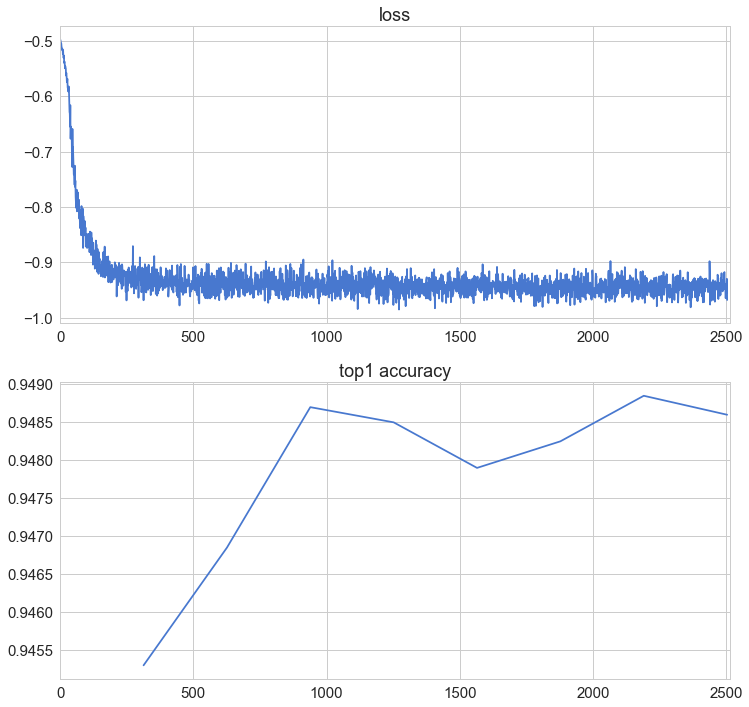

In [25]:
model.save_tensorflow([("input", [1, 3])], "/tmp/model.pb")

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


# Predict on test set

In [26]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

In [27]:
predictions = trained_model.predict(test_data)

In [28]:
%%time
predictions = trained_model.predict(test_data)
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(50)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(50)))

Ground Truth labels:
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1
Predicted labels:
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1
CPU times: user 11.5 ms, sys: 3.03 ms, total: 14.6 ms
Wall time: 141 ms


In [29]:
labels = [map_groundtruth_label(s.label.to_ndarray()) for s in test_data.take(20000)]
df_prediction = pd.DataFrame({'Real Class' :np.array(labels)})
predicted_labels = [map_predict_label(s) for s in predictions.take(20000)]
df_prediction['Prediction'] = predicted_labels

In [30]:
total_size = X_test.shape[0]
mismatch_size = df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ].size
accuracy = ((total_size - mismatch_size) / total_size) * 100
print(total_size)
print(mismatch_size)
print(accuracy)

19999
2052
89.73948697434871


## Predict on a new dataset

In [31]:
df = pd.read_csv("data/CPU_examples_test.csv")

## standardize and widen
df['CPU'] = df['CPU'].apply(lambda x: (x - scaler_mean) / scaler_var)
X_test = widenX(lookback, df['CPU'])
Y_test = widenY(lookback, df['Class'])

print(X_test.shape)
anomaly = df[df.Class == 1]
anomaly.shape

(49999, 3)


(8365, 3)

In [32]:
def get_rdd_from_ndarray_test(sc):
    rdd_X_test = sc.parallelize(X_test)
    rdd_Y_test = sc.parallelize(Y_test)

    rdd_test_sample = rdd_X_test.zip(rdd_Y_test).map(lambda labeledFeatures:
                                     common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    return rdd_test_sample

test_data = get_rdd_from_ndarray_test(sc)

In [33]:
%%time
predictions = trained_model.predict(test_data)
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(50)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(50)))

Ground Truth labels:
0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
Predicted labels:
0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
CPU times: user 12.4 ms, sys: 3.14 ms, total: 15.5 ms
Wall time: 133 ms


In [34]:
labels = [map_groundtruth_label(s.label.to_ndarray()) for s in test_data.take(X_test.shape[0])]
df_prediction = pd.DataFrame({'Real Class' :np.array(labels)})
predicted_labels = [map_predict_label(s) for s in predictions.take(X_test.shape[0])]
df_prediction['Prediction'] = predicted_labels

In [35]:
total_size = X_test.shape[0]
mismatch_size = df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ].size
accuracy = ((total_size - mismatch_size) / total_size) * 100
print(total_size)
print(mismatch_size)
print(accuracy)

49999
5356
89.2877857557151
